In [13]:
import csv
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

src_path = './Assign-1-data/'
train_path = src_path + 'train.csv'
valid_path = src_path + 'valid.csv'
test_path = src_path + 'test.csv'

dst_path = './Assign-1-result/'
matrix_path = dst_path + 'matrix.csv'
saved_path = dst_path + 'res.csv'
user_ave_path = dst_path + 'user_ave.csv'
item_ave_path = dst_path + 'item_ave.csv'
sim_path = dst_path + 'isim_cos.csv'
neighbor_path = dst_path + 'ineighbor_sorted.csv'
valid_res_path = dst_path + 'valid_res.csv'
################################

class CF:
    def __init__(self):
        pass

    def split_valid_data(self, path, to_path, rate, round):
        f = csv.reader(open(path,'r'))  # 源
        writer = csv.writer(open(to_path, 'w', newline='')) # 写入验证集
        start = int(32602 * rate * round)       # valid data 起点
        total = int(32602 * rate)
        idx, cnt = 0, 0
        for i in f:
            if i[0] == 'user_id':
                writer.writerow(i)
                continue
            if ( idx < start ):
                idx += 1
                continue
            # 当前条目的用户编号和商品编号
            unum, inum = self.user_dict[i[0]], self.item_dict[i[1]]
            # 保证有足够的训练集
            if ( self.user_active[unum] >= 5 and self.item_active[inum] >= 5 ):
                # 写入验证集
                writer.writerow(i)
                # 从训练集中去除
                # self.user_active[unum] -= 1
                # self.item_active[inum] -= 1
                # self.matrix[unum][inum] = 0
                cnt += 1
            if ( cnt == total ): # 收集满total条验证集
                break
        # 输出 ui_matrix
        matwriter = csv.writer(open(matrix_path,'w',newline=''))
        for i in range (len(self.matrix)):
            matwriter.writerow(self.matrix[i])
        return self

    def load_train_data(self, path):
        user, item = {}, {}
        i, j = 0, 0
        reader = csv.reader(open(path,'r'))
        for k in reader: # 编号
            if k[0] == 'user_id':
                continue
            uid, iid = k[0], k[1]
            if uid not in user:
                user[uid]=i
                i+=1
            if iid not in item:
                item[iid]=j
                j+=1
        self.user_dict=user
        self.item_dict=item
        self.matrix = np.zeros((len(self.user_dict),len(self.item_dict)))
        # 用户、商品活跃度（相关评分数量）
        self.user_active = np.zeros(len(self.user_dict))
        self.item_active = np.zeros(len(self.item_dict))
        reader = csv.reader(open(path,'r'))
        for line in reader:
            if line[0] == 'user_id':
                continue
            self.matrix[self.user_dict[line[0]]][self.item_dict[line[1]]]=eval(line[2])
            self.user_active[self.user_dict[line[0]]] += 1 # 更新用户活跃度
            self.item_active[self.item_dict[line[1]]] += 1 # 更新商品活跃度
        self.matrix=self.matrix.astype(np.float32)
        # 输出 ui_matrix
        matwriter = csv.writer(open(matrix_path,'w',newline=''))
        for i in range (len(self.matrix)):
            matwriter.writerow(self.matrix[i])
        return self

    def init(self):
        self.able = 0
        self.all_user_ave = 0
        self.all_item_ave = 0
        self.sim = np.zeros((len(self.item_dict)*10, len(self.item_dict)*10))
        self.user_ave_score = np.zeros((len(self.user_dict), 1))
        self.item_ave_score = np.zeros((len(self.item_dict), 1))
        self.neighbor = np.zeros((len(self.item_dict)*10, len(self.item_dict)*10))
    
    def user_ave_cal(self, to_path):
        # 计算每个用户的平均给分
        for unum in range(len(self.user_dict)):
            score, cnt = 0, 0
            for item in range(len(self.item_dict)):
                if ( self.matrix[unum][item] != 0 ):
                    score += self.matrix[unum][item]
                    cnt += 1
            self.user_ave_score[unum] = score / cnt
            self.all_user_ave += self.user_ave_score[unum]
        self.all_user_ave = self.all_user_ave / len(self.user_dict)
        print("all_user_ave %.5f"%self.all_user_ave)
        # 导出
        writer = csv.writer(open(to_path,'w',newline=''))
        for i in range (len(self.user_ave_score)):
            writer.writerow(self.user_ave_score[i])
        return self

    def load_user_ave(self, path):
        reader = csv.reader(open(path,'r'))  # 源
        i = 0
        for line in reader: # 每一行
            j = 0
            for e in line:  # 每一个元素
                self.user_ave_score[i][j] = e
                j += 1
            i += 1
        return self

    def item_ave_cal(self, to_path):
        # 计算每个商品的平均得分
        for item in range(len(self.item_dict)):
            score, cnt = 0, 0
            for u in range(len(self.user_dict)):
                if ( self.matrix[u][item] != 0 ):
                    score += self.matrix[u][item]
                    cnt += 1
            self.item_ave_score[item] = score / cnt
            self.all_item_ave += self.item_ave_score[item]
        self.all_item_ave = self.all_item_ave / len(self.item_dict)
        print("all_item_ave %.5f"%self.all_item_ave)
        # 导出
        writer = csv.writer(open(to_path,'w',newline=''))
        for i in range (len(self.item_ave_score)):
            writer.writerow(self.item_ave_score[i])
        return self
    
    def load_item_ave(self, path):
        reader = csv.reader(open(path,'r'))  # 源
        i = 0
        for line in reader:
            j = 0
            for e in line:
                self.item_ave_score[i][j] = e
                j += 1
            i += 1
        return self
        
    def load_sim(self, path):
        reader = csv.reader(open(path,'r'))  # 源
        i = 0
        for line in reader: # 每一行 sim[a]
            j = 0
            for e in line:  # 每一个元素，sim[a][b]
                self.sim[i][j] = e
                j += 1
            i += 1
        return self
    
    # 按相似度从高到底为邻居排序
    def neighbor_sort(self, to_path):
        for i in range (len(self.neighbor)):
            self.neighbor[i] = self.sim[i].argsort()[::-1]
        writer = csv.writer(open(to_path,'w',newline=''))
        for i in range (len(self.neighbor)):
            writer.writerow(self.neighbor[i])
        return self
    
    def predict_1rating(self, unum, inum):
        '''
        根据共现矩阵，计算一次rating
        '''
        r_u = self.user_ave_score[unum]
        total, weigh = 0, 0
        cnt = 0
        pred_ui = 0
        sim = []
        for i in range(len(self.item_dict)):
            item = int(self.neighbor[inum][i]) # 当前考察的邻居
            if ( item == inum ):
                continue
            # 调整相似度阈值 #########################
            if ( self.sim[item][inum] < 2 ):
            ##########################################
                break
            r_ui = self.matrix[unum][item] # u对inum的邻居item的打分
            if ( r_ui > 0 ):
                total += self.sim[item][inum] * r_ui
                weigh += self.sim[item][inum]
                sim.append(self.sim[item][inum])
                cnt += 1
        if ( abs(weigh) < 1e-10 ): # user没有交互过相似物品
            # pred_ui = self.all_user_ave
            pred_ui = self.user_ave_score[unum]
            #  self.user_ave_score[unum]
        else:
            pred_ui = total / weigh
            self.able += 1
            print(unum, inum, sim, pred_ui)
        if ( pred_ui < 1 ):
            pred_ui = self.all_user_ave
        if ( pred_ui > 5 ):
            pred_ui = self.all_user_ave
        return np.squeeze(pred_ui)

    def predict_RMSE(self, path, to_path):
        '''
        提供一个计算RMSE的方法
        '''
        predicted_list=[]
        gt_rate_list=[]
        #1.read valid data & compute scores
        f = csv.reader(open(path,'r'))
        self.able = 0
        for i in f:
            if i[0] == 'user_id':
                continue
            unum,inum,gt_rate = self.user_dict[i[0]],self.item_dict[i[1]],eval(i[2])
            predicted_score = self.predict_1rating(unum, inum)
            predicted_list.append(predicted_score)
            gt_rate_list.append(gt_rate)
        RMSE = 0.0
        #2.compute RMSE
        data_len=len(predicted_list)
        RMSE=sum([((predicted_list[i]-gt_rate_list[i])**2) / data_len for i in range(data_len)]) ** 0.5
        print('RMSE',RMSE)
        print('able',self.able)
        
        # 输出验证集测试结果
        writer = csv.writer(open(valid_res_path,'w', newline=''))
        for i in range(len(predicted_list)):
            writer.writerow([gt_rate_list[i], predicted_list[i]])
        
        # 可视化预测结果
        plt.style.use('ggplot')
        plt.figure(figsize=(15, 4))
        plt.scatter([i for i in range(len(predicted_list))], gt_rate_list, alpha=0.8, label='rate')
        plt.scatter([i for i in range(len(predicted_list))], predicted_list, alpha=0.8, label='predicted rate')
        plt.legend(loc=[1, 1], fontsize=10)
        plt.title('Prediction results on the validation set (RMSE: %.5f)'%RMSE)
        plt.xlabel('index')
        plt.ylabel('score')
        return RMSE
    
    def save_pred(self, path, to_path):
        f = csv.reader(open(path,'r'))
        writer = csv.writer(open(to_path,'w', newline=''))
        writer.writerow(['idx','rate'])
        cnt = 0
        self.able = 0
        for i in f:
            if i[0] == 'user_id':
                continue
            unum,inum = self.user_dict[i[0]],self.item_dict[i[1]]
            predicted_score = self.predict_1rating(unum, inum)
            writer.writerow([cnt,predicted_score])
            cnt += 1
        print('able',self.able)
        return self

In [14]:
# 划分训练集/验证集
model=CF()
model.load_train_data(train_path)
# model.split_valid_data(train_path, valid_path, 1, 0)
model.init()

In [15]:
model.user_ave_cal(user_ave_path)
model.item_ave_cal(item_ave_path)
#model.load_user_ave(user_ave_path)
#model.load_item_ave(item_ave_path)

all_user_ave 3.81619
all_item_ave 3.75483


In [16]:
# 计算 similarity C++
# RMSE 0.7972815152462499  0.8 sua
# RMSE 0.7594523921575412  0.6  able 22049  sua
# RMSE 0.751105908386511   0.5 able 22669
# RMSE 0.7483638974356236  0.4 # able 23018

In [17]:
sim_path = dst_path + 'isim.csv'
neighbor_path = dst_path + 'ineighbor_sorted.csv'
model.load_sim(sim_path)
model.neighbor_sort(neighbor_path)

RMSE 0.968618756034917
able 0


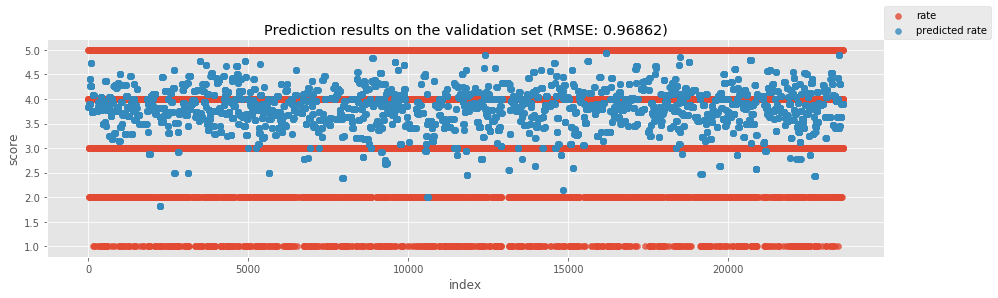

In [18]:
rmse = model.predict_RMSE(valid_path, valid_res_path)

In [19]:
saved_path = dst_path + 'res_icf.csv'
model.save_pred(test_path,saved_path)

able 0


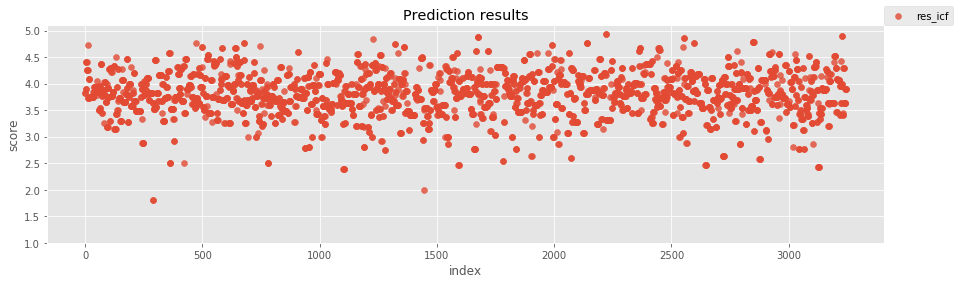

In [20]:
sub_path = './Assign-1-result/'

# 需要可视化的文件名
score = ['res_icf']

# 可视化预测结果
plt.style.use('ggplot')
plt.figure(figsize=(15, 4))
for s in range(len(score)):
    f = csv.reader(open(sub_path+score[s]+'.csv','r'))  # 源
    idx = np.zeros(3246)
    pre = np.zeros(3246)
    cnt = 0
    for k in f:
        if k[0] == 'idx':
            continue
        idx[cnt] = eval(k[0])
        pre[cnt] = eval(k[1])
        cnt += 1
    plt.scatter(idx, pre, alpha=0.8, label=score[s])

plt.legend(loc=[1, 1], fontsize=10)
plt.title('Prediction results')
plt.xlabel('index')
plt.ylabel('score')
plt.yticks((1,1.5,2,2.5,3,3.5,4,4.5,5))
plt.show()